# Numerical Integration of Differential Equations: The Damped Harmonic Oscillator

*Lili Kovacs<br>
University of Manchester  
April 2023*

In this project, the behaviour of a damped harmonic oscillator is studied using different numerical methods.

First, the spring-mass system is studied in the case of no external force applied using two versions of the Euler Method, the Verlet Method and the Euler-Cromer Method. The analytical solution to this setup is then used to verify the accuracy of these methods by looking at the energy of the system and the best ones are used to study the system in different damping scenarios and with a sudden or periodic (sinusoidal) force applied to it.

The spring-mass system is described by the following equation of motion: 

\begin{equation}
\tag{1}
mx''(t)+bx'(t)+kx(t)=F(t),
\end{equation}

where $m$ [kg] is the mass, $b$ [kg/s] is the damping constant and $k$ [kg/s$^2$] is the spring constant.

Rearranging the equation and substituting in the appropriate time derivatives of the displacement, the system is completely described by position and velocity at any time $t$ if there is no external force applied:

\begin{equation}
\tag{2}
a(t)=-\frac{k}{m}x(t)-\frac{b}{m}v(t).
\end{equation}

The properties of the oscillating system we are studying are the following:

In [1]:
m = 4.53 #in kg
k = 1.59 #in kg/s**2

We initialise our Python interpreter by we importing any libraries used and defining some plotting parameters.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

## Analytical solution for $F(t) = 0$

The analytical solution is useful for us to be able to benchmark our code and see how close each numerical solution is to reality. This way we can use one that is accurate enough for when we don't have a simple way of finding an analytical solution to describe the system.

Depending on the value of the damping constant and the properties of the system, there are three distint solutions that satisfy the equation of motion. We define the damping ratio, $\gamma = b/m$ and the natural (undamped) frequency of the oscillator, $\omega_0 = \sqrt{k/m}$. The frequency of the damped system can be calculated from $\omega = \sqrt{\omega_0^2 - \gamma^2/4}$.

For light damping (or underdamped system), $\omega_0^2 > \gamma^2/4$. In this case, the system will oscillate about its equilibrium with an exponentially decaying amplitude. 

For heavy damping (or overdamped system), $\omega_0^2 < \gamma^2/4$. No oscillations occur and the mass slowly returns to rest from the initial conditions.

For critical damping, $\omega_0^2 = \gamma^2/4$. The system returns to equilibrium in the shortest possible time without oscillating. From this, we can also define the value of the critical damping constant, $b_{critical} = \sqrt{4km}$.

The solution to the equation of motion is
\begin{gather*}
\tag{3}
x(t)=e^{\frac{-\gamma t}{2}}(Ae^{i\omega t}+Be^{-i\omega t}) \\
v(t)=e^{\frac{-\gamma t}{2}}(Ae^{i\omega t}[-\frac{\gamma}{2}+i\omega]-Be^{-i\omega t}[\frac{\gamma}{2}+i\omega]),
\end{gather*}

where $A$ and $B$ are determined from the initial conditions: at $t=0$, $x=x_0$ and $v=v_0$.

In the critical damping case, $\omega = 0$ and therefore the exponentials after $A$ and $B$ disappear. The solution simplifies to the following form:
\begin{gather*}
\tag{4}
x(t)=e^{\frac{-\gamma t}{2}}(A+Bt) \\
v(t)=e^{\frac{-\gamma t}{2}}[\frac{-\gamma}{2}(A+Bt)+B].
\end{gather*}

In [3]:
def Analytical (x_initial, v_initial, time):
    """
    returns displacement and velocity of the oscillating system at a time, given the initial conditions
    """
    b_crit = 2*np.sqrt(k*m)
    gamma = b/m
    omega_0 = np.sqrt(k/m)
    omega = cmath.sqrt(omega_0**2-gamma**2/4)
    
    if b == b_crit:
        A = x_initial
        B = v_initial + x0*gamma/2
        x = np.exp(-gamma*time/2)*(A+B*time)
        v = np.exp(-gamma*time/2)*(-gamma/2*(A+B*time)+B)
    else:
        A = (b/(2*1j*cmath.sqrt(4*k*m-b**2))+1/2)*x_initial +(v_initial*m)/(cmath.sqrt(4*k*m-b**2)*1j)
        B = x_initial - A
        x = np.exp(-gamma*time/2)*(A*np.exp(1j*omega*time)+B*np.exp(-1j*omega*time))
        v = np.exp(-gamma*time/2)*(A*np.exp(1j*omega*time)*(-gamma/2+1j*omega)-B*np.exp(-1j*omega*time)*(gamma/2+1j*omega))
    x = x.real
    v = v.real
    
    return (x, v)

## Numerical integration methods

Numerical methods allow to solve a problem following an algorithm (usually an iterative procedure). While they are not exact like analytical solutions, they are useful for when an analytical solution doesn't exist or would be too time-consuming.

Using the value of a function at a given time (for example, the initial conditions), its value at another time can be estimated by adding on a small change (or a sum of them): $\delta y = \frac{dy}{dt}\delta t = \frac{dy}{dt}h$ for a function $y(t)$, where $h$ is a chosen time step.

The methods used to study the spring-mass in this project system are introduced below.

### Euler method

A first order Taylor explansion of $x(t)$ gives
\begin{equation}
\tag{5}
x(t+h) = x(t) + hx'(t) + error
\end{equation}

The error on this value comes from the truncation of the expansion and is of order $h^2$.


After a small time step, $h$, the displacement and the velocity can therefore be written as:
\begin{equation}
\tag{6}
x(t+h)=x(t)+hv(t), \\
v(t+h)=v(t)+ha(t).
\end{equation}
    
If we rewrite these equation using the number of steps, $i$, we produce a way of calculating these at each step using the values from the previous step (starting from initial conditions).
\begin{equation}
\tag{7}
x_{i+1}=x_i+hv_i, \\
v_{i+1}=v_i+ha_i,
\end{equation}
with
\begin{equation}
\tag{8}
a_i=-\frac{k}{m}x_i-\frac{b}{m}v_i.
\end{equation}

These are the relations that the Euler method uses.

In [4]:
def Euler(x_initial, v_initial, nsteps, stepsize):
    """
    returns an array of displacements and velocities using the Euler method,
    given a step size, total number of steps and initial conditions
    """
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x_initial
    v[0]= v_initial
    
    for i in range(nsteps-1):
        #acceleration at step i (in m/s)
        a = -(k/m)*x[i] - (b/m)*v[i]
        x[i+1] = x[i] + stepsize*v[i]
        v[i+1] = v[i] + stepsize*a
        
    return (x, v)

### Improved Euler method

An easy way to improve our estimates from the Euler method is including higher order terms in the Taylor expansion. Here, we included them up to second order:

\begin{equation}
\tag{9}
x(t+h)=x(t)+hx'(t)+\frac{1}{2}h^2x''(t) + error
\end{equation}

The local truncation error in this case is of order $h^3$.

Our expressions for $x$ and $v$ become 

\begin{equation}
\tag{10}
x_{i+1}=x_i+hv_i+\frac{h^2}{2}a_i, \\
v_{i+1}=v_i+ha_i,
\end{equation}
where $a_i$ can be found the same way as in Equation (8).

In [5]:
def Improved_Euler(x_initial, v_initial, nsteps, stepsize):
    """
    returns an array of displacements and velocities using an improved version of the Euler method,
    given a step size, total number of steps and initial conditions
    """
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x_initial
    v[0]= v_initial
    
    for i in range(nsteps-1):
        #acceleration at step i (in m/s)
        a = -(k/m)*x[i] - (b/m)*v[i]
        x[i+1] = x[i] + stepsize*v[i] + stepsize**2*a/2
        v[i+1] = v[i] + stepsize*a
        
    return (x, v)

### Verlet method

The Verlet method uses a centred derivative and defines velocity as $x'(t)=\lim_{h \to 0} \frac{x(t+h)-x(t-h)}{2h}$. Two Taylor expansions are needed, one for $x(t+h)$ and one for $x(t-h)$:
\begin{equation}
\tag{11}
x(t+h)=x(t)+hx'(t)+\frac{1}{2}h^2x''(t)+\frac{1}{6}h^3x'''(\zeta), \\
x(t-h)=x(t)-hx'(t)+\frac{1}{2}h^2x''(t)-\frac{1}{6}h^3x'''(\zeta),
\end{equation}
where $t-h < \zeta < t+h$.

Rearranging and combining these gives us
\begin{equation}
\tag{12}
x_{i+1}=Ax_i+Bx_{i-1} \\
v_i=\frac{x_{i+1}-x_{i-1}}{2h}
\end{equation}
with $A=2\frac{(2m-kh^2)}{D}, B=\frac{bh-2m}{D}, D=2m+bh$.

The error on these is of order $h^4$, so this seems to be a more accurate method than the previous ones, however, it is not self-starting: $x_{i+1}$ requires both $x_i$ and $x_{i-1}$. We need to use a different method to find the first step after the initial conditions. (This code uses the Improved Euler method, as the errors are estimated to be smaller for it.)

In [6]:
def Verlet(x_initial, v_initial, nsteps, stepsize):
    """
    returns an array of displacements and velocities using the Verlet method,
    given a step size, total number of steps and initial conditions
    """
    D = 2*m+b*stepsize
    A = 2*(2*m-k*stepsize**2)/D
    B = (b*stepsize-2*m)/D
    
    x = np.zeros(nsteps+1) #these arrays are made longer to make sure there is an i+1th step for the last velocity value
    v = np.zeros(nsteps+1)
    x[0] = x_initial
    x[1] = Improved_Euler(x_initial,v_initial,nsteps,stepsize)[0][1] #the second position needs to be defined using a different method
    v[0] = v_initial
            
    for i in range(1, nsteps):
        x[i+1] = A*x[i]+B*x[i-1]
        v[i] = (x[i+1]-x[i-1])/(2*stepsize)
    
    return (x[:-1], v[:-1])

### Euler-Cromer method

This method is nearly identical to the Euler method, the modification being replacing $v_i$ with $v_{i+1}$ to conserve the overall energy of the system: the Euler-Cromer is therefore a symplectic (energy conserving) integrator.

The equations for displacement and velocity are now the following:
\begin{equation}
\tag{13}
x_{i+1}=x_i+hv_{i+1}, \\
v_{i+1}=v_i+ha_i,
\end{equation}
where $a_i$ is defined by Equation (8).

In [7]:
def Euler_Cromer(x_initial, v_initial, nsteps, stepsize):
    """
    returns an array of displacements and velocities using the Euler-Cromer method,
    given a step size, total number of steps and initial conditions
    """
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x_initial
    v[0]= v_initial
    
    for i in range(nsteps-1):
        # acceleration at step i
        a = -(k/m)*x[i] - (b/m)*v[i]
        v[i+1] = v[i] + stepsize*a
        x[i+1] = x[i] + stepsize*v[i+1]
        
    return (x, v)

## Initial Parameters

For the numerical methods, we need to define initial conditions ($x_0$ and $v_0$) along with the integration time $T$, step size $h$ and the number of steps.

In [8]:
x0 = 0 #initial position (equilibrium, 0 displacement) in m
v0 = -1 #initial velocity in m/s

T = 240 #total integration time in s
h = 0.01 #step size
stepnumber = int(T/h) #number of steps, has to be an integer

## Choosing appropriate damping constant

To model the oscillation, an appropriate value of the damping constant, $b$ needs to be chosen. The displacement is plotted for a range of $b$ values below, several lower than, one at, and one over the critical value, which was calculated to be $b_{critical} = 5.36757$.

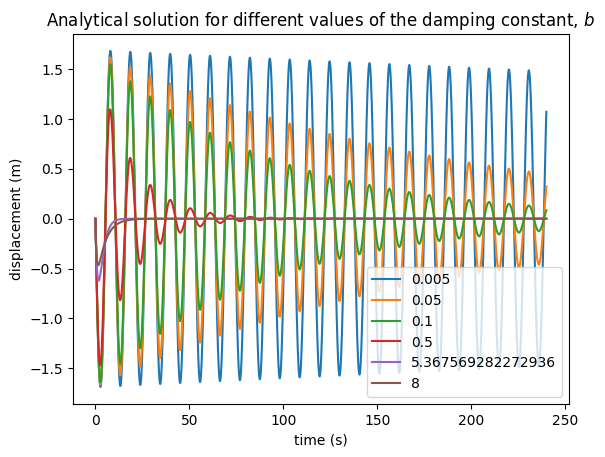

In [9]:
B = (0.005, 0.05, 0.1, 0.5, 5.367569282272936, 8)
for b in B:
    plt.plot(np.arange(0,T,h), Analytical(x0, v0, np.arange(0,T,h))[0], label=(b))
plt.legend()
plt.title('Analytical solution for different values of the damping constant, $b$')
plt.xlabel('time (s)')
plt.ylabel('displacement (m)')
plt.show()

A value of $b = 0.1$ was chosen. At this value, the analytical solution demonstrates the exponential decay of the oscillation amplitude well. For values higher than this, the oscillations die down faster, while for lower, they show less change in amplitude within the chosen integration time.

In [10]:
b = 0.1 #damping constant

## Displacement plots

In [11]:
#get displacement and velocity values for all four numerical methods and the analytical solution
x_an, v_an = Analytical(x0, v0, np.arange(0,T,h))
x_euler, v_euler = Euler(x0,v0,stepnumber,h)
x_impr, v_impr = Improved_Euler(x0,v0,stepnumber,h)
x_verlet, v_verlet = Verlet(x0,v0,stepnumber,h)
x_eucr, v_eucr = Euler_Cromer(x0,v0,stepnumber,h)

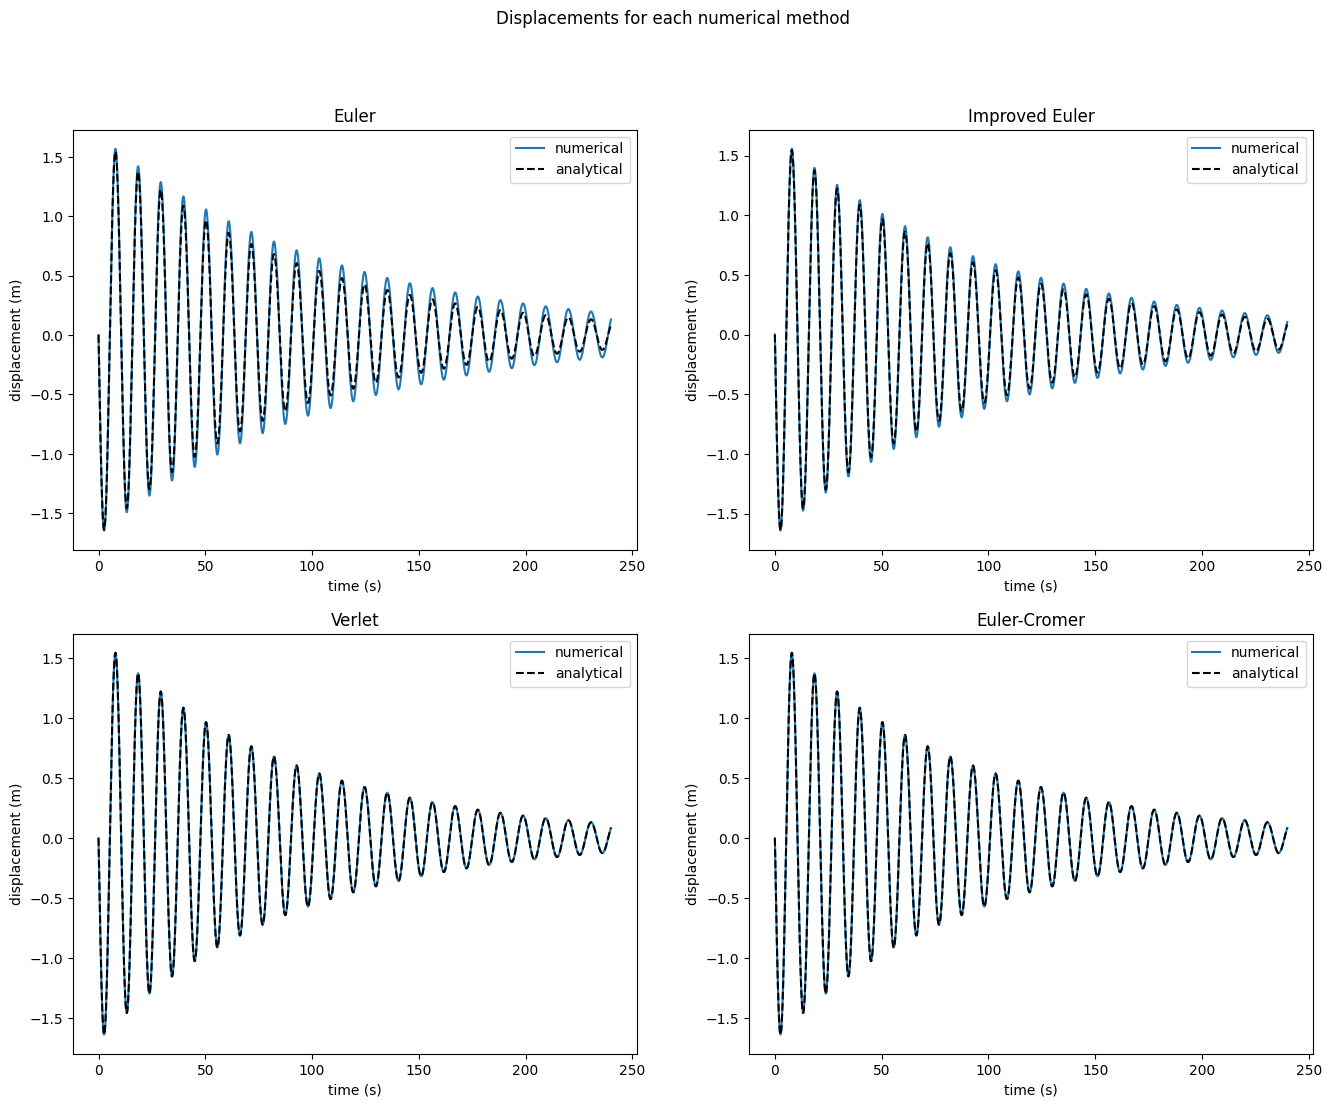

In [12]:
def displacement_subplot(row,col,displacement,title):
    """
    plots the displacement values for a numerical method along with the analytical solution on the chosen subplot
    """
    ax[row,col].plot(np.arange(0,T,h), displacement, label = 'numerical')
    ax[row,col].plot(np.arange(0,T,h), x_an, 'k--', label = 'analytical')
    ax[row,col].set_title(title)
    ax[row,col].set_xlabel('time (s)')
    ax[row,col].set_ylabel('displacement (m)')
    ax[row,col].legend()
    
fig, ax = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(16)
fig.suptitle('Displacements for each numerical method')

displacement_subplot(0,0,x_euler,"Euler")
displacement_subplot(0,1,x_impr,"Improved Euler")
displacement_subplot(1,0,x_verlet,"Verlet")
displacement_subplot(1,1,x_eucr,"Euler-Cromer")

plt.show()

The plots above display the displacement values calculated using the analytical methods in blue and the corresponding values of the analytical solution with the black dashed lines. Just by looking at them, we can see, that for the parameters that we have been using ($x_0, v_0, T, h, b$), the motions predicted by the Verlet and Euler-Cromer methods are close to reality (as they overlap with the analytical solution) while the Euler and the Improved Euler methods predict a slower decay in amplitude than the analytical solution.

## Effect of step size

To quantify the accuracy of the methods, we first study how changing the step size affects the results. We define a range of step sizes (with different orders of magnitude) and plot the displacement for each of them on the same plot, along with the analytical solution.

In [13]:
#define a range of step sizes and colours assigned to them
stepsizes = (0.005,0.01,0.05,0.1)
colours = ('b', 'm', 'g', 'c')

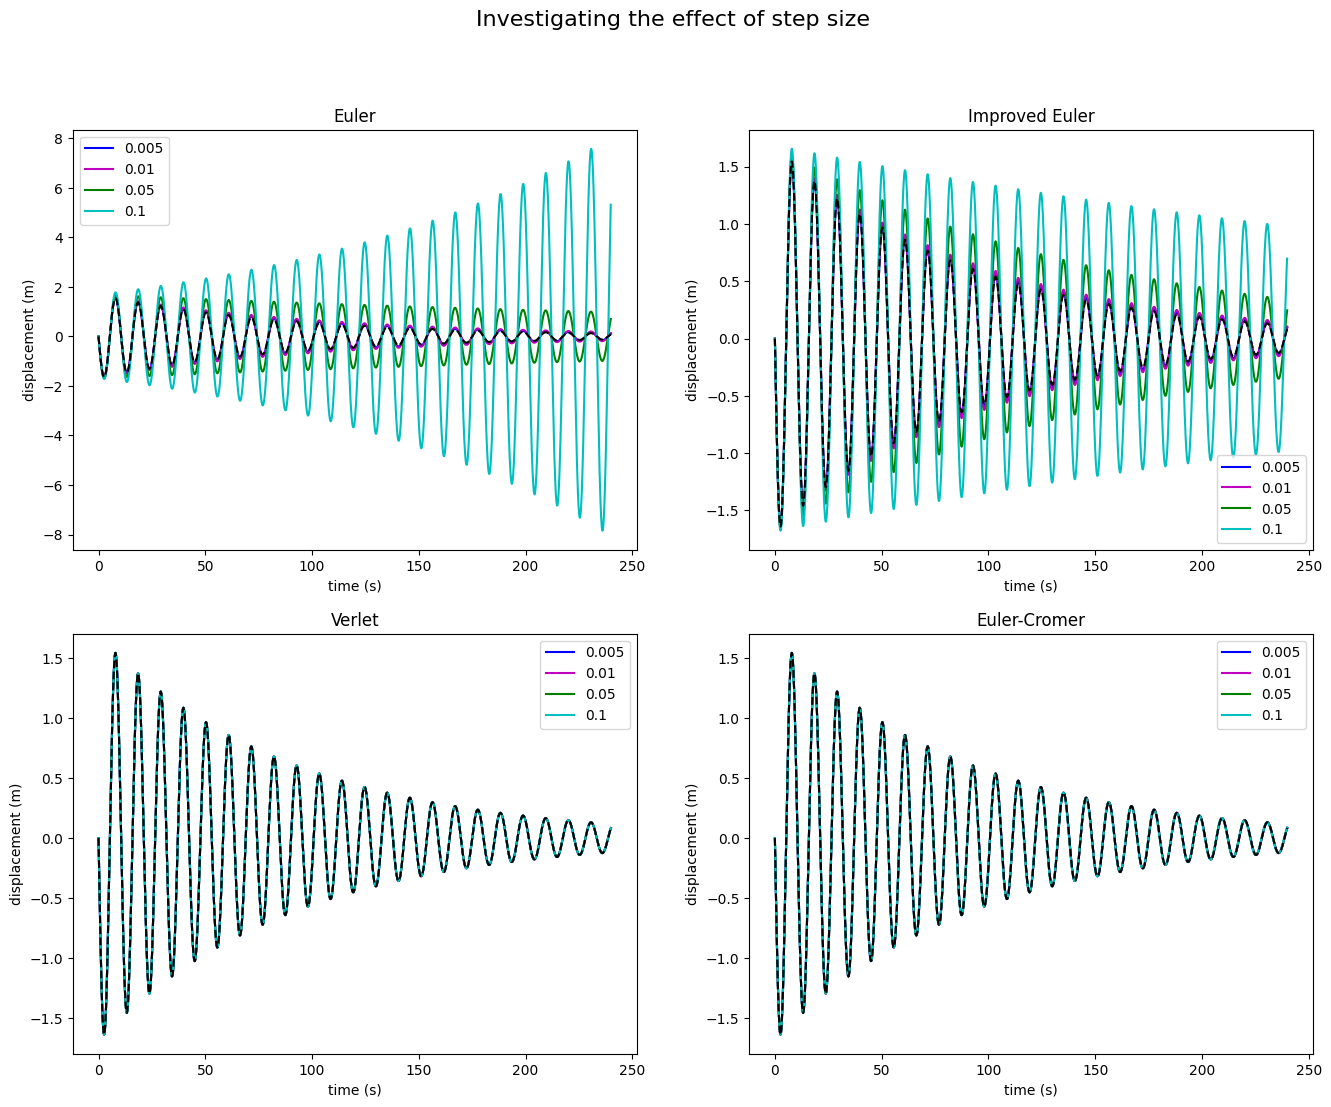

In [14]:
def stepsize_subplot(row, col, method, title):
    """
    plots the displacement values for a range of step sizes along with the analytical solution on the chosen subplot
    """
    for index, hstep in enumerate(stepsizes):
        stepnumber=int(T/hstep)
        x, v=method(x0,v0,stepnumber,hstep)
        ax[row,col].plot(np.arange(0,T,hstep),x,label=(hstep), color = colours[index])
    ax[row,col].plot(np.arange(0,T,h), Analytical(x0,v0,np.arange(0,T,h))[0], 'k--')
    ax[row,col].set_xlabel("time (s)")
    ax[row,col].set_ylabel("displacement (m)")
    ax[row,col].set_title(title)
    ax[row,col].legend()

fig, ax = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(16)
fig.suptitle("Investigating the effect of step size", fontsize=16)

stepsize_subplot(0, 0, Euler, "Euler")
stepsize_subplot(0, 1, Improved_Euler, "Improved Euler")
stepsize_subplot(1, 0, Verlet, "Verlet")
stepsize_subplot(1, 1, Euler_Cromer, "Euler-Cromer")

plt.show()

These plots reinforce what we've already stated. The Verlet and Euler-Cromer method seem to be accurate while for the Euler and the Improved Euler method, there is a problem: by varying the step size, we vary the energy of the system. For a step size of $0.01$ seconds or smaller, the displacements predicted by them are in agreement with the analytical solution. However, for the step sizes larger than this, the amplitude of oscillations increases as if energy was added to the system, instead of exponentially decaying.

The Euler and Improved Euler methods do not conserve energy, while the Verlet and Euler-Cromer methods seem to: they are symplectic integrators.

## Energies

To verify the accuracy of these methods, we can look at the energy of the system. For a harmonic oscillator, the total energy of the system is 
\begin{equation}
\tag{14}
E = \frac{1}{2}mv^2+\frac{1}{2}kx^2.
\end{equation}

In [15]:
def Energy (x,v):
    E = 1/2*m*v**2 + 1/2*k*x**2
    return E

We can plot the energies for the same step sizes as before to see that by varying the step size, we are indeed affecting the accuracy of the first two methods, while for the last two, it seems to be independent of step size.

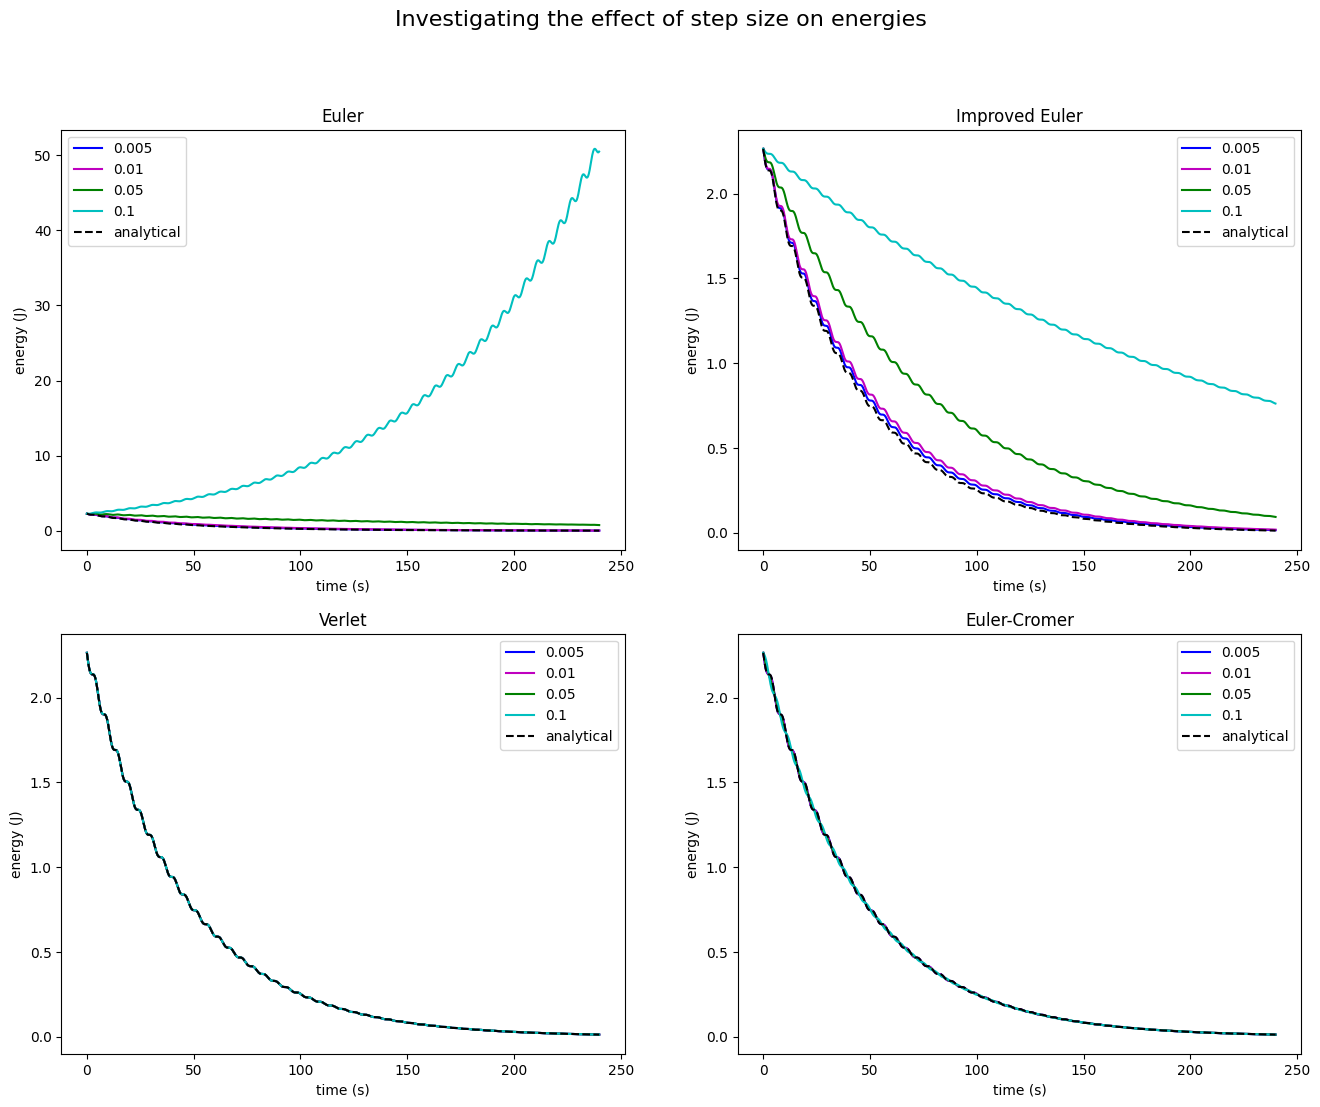

In [16]:
def energy_subplot(row, col, method, title):
    """
    plots the time evolution of the energy of the oscillating system for a range of step sizes
    along with the analytical solution on the chosen subplot
    """
    for index, hstep in enumerate(stepsizes):
        stepnumber=int(T/hstep)
        x, v = method(x0,v0,stepnumber,hstep)
        ax[row,col].plot(np.arange(0,T,hstep), Energy(x, v),label=(hstep), color = colours[index])
    ax[row,col].plot(np.arange(0,T,h), Energy(Analytical(x0,v0,np.arange(0,T,h))[0], Analytical(x0,v0,np.arange(0,T,h))[1]), 'k--', label = 'analytical')
    ax[row,col].set_xlabel("time (s)")
    ax[row,col].set_ylabel("energy (J)")
    ax[row,col].set_title(title)
    ax[row,col].legend()

fig, ax = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(16)
fig.suptitle("Investigating the effect of step size on energies", fontsize=16)

energy_subplot(0, 0, Euler, "Euler")
energy_subplot(0, 1, Improved_Euler, "Improved Euler")
energy_subplot(1, 0, Verlet, "Verlet")
energy_subplot(1, 1, Euler_Cromer, "Euler-Cromer")

plt.show()

We can quantify these deviations from the analytical solution and therefore choose the best methods by calculating an error on the energy for each method. We can do this, for example, by summing over the difference between the predicted and calculated energies at each point weighted by the value of the analytical solution and then dividing the result by the number of steps (as this varies with step size):
\begin{equation}
\tag{15}
\sigma = \frac{1}{N}\sum_{i=1}^{N}\frac{|E_{numerical, i}-E_{analytical, i}|}{E_{analytical, i}}.
\end{equation}

In [17]:
def energy_errors(hstep):
    """
    calculates the error according to Equation (15) for all four numerical methods for a given time step
    """
    nstep = int(T/hstep)
    E_an = Energy(Analytical(x0, v0, np.arange(0,T,hstep))[0], Analytical(x0, v0, np.arange(0,T,hstep))[1])
    E_euler = Energy(Euler(x0, v0, nstep, hstep)[0], Euler(x0, v0, nstep, hstep)[1])
    if len(E_an) != len(E_euler):
        E_an = E_an[:-1] #for some cases, the analytical solution returns an extra timestep, so this is necessary for the code to work
    E_impr = Energy(Improved_Euler(x0, v0, nstep, hstep)[0], Improved_Euler(x0, v0, nstep, hstep)[1])
    E_verlet = Energy(Verlet(x0, v0, nstep, hstep)[0], Verlet(x0, v0, nstep, hstep)[1])
    E_eucr = Energy(Euler_Cromer(x0, v0, nstep, hstep)[0], Euler_Cromer(x0, v0, nstep, hstep)[1])
    
    N = len(E_an)
    
    error_euler = np.sum(np.abs(E_euler-E_an)/E_an)/N
    error_impr = np.sum(np.abs(E_impr-E_an)/E_an)/N
    error_verlet = np.sum(np.abs(E_verlet-E_an)/E_an)/N
    error_eucr = np.sum(np.abs(E_eucr-E_an)/E_an)/N
    
    
    return error_euler, error_impr, error_verlet, error_eucr

We can then create a whole range of step sizes instead of a few specific values and plot the error on the energy for each method against stepsize.

In [18]:
H = np.linspace(0.001, 0.1, 50)

err_euler=np.zeros(len(H))
err_impr=np.zeros(len(H))
err_verlet=np.zeros(len(H))
err_eucr=np.zeros(len(H))

for val in range(len(H)):
    err_euler[val], err_impr[val], err_verlet[val], err_eucr[val] = energy_errors(H[val])

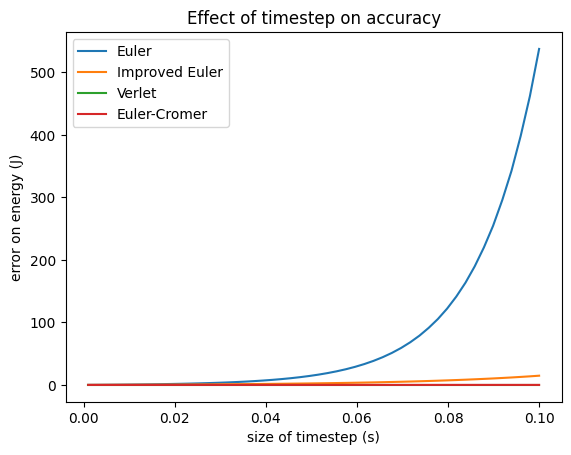

In [19]:
plt.plot(H, err_euler, label = 'Euler')
plt.plot(H, err_impr, label = 'Improved Euler')
plt.plot(H, err_verlet, label = 'Verlet')
plt.plot(H, err_eucr, label = 'Euler-Cromer')
plt.legend()
plt.title('Effect of timestep on accuracy')
plt.xlabel('size of timestep (s)')
plt.ylabel('error on energy (J)')
plt.show()

In agreement with the error predicted by the method, we can see that its value increases fastest for the Euler method (where the error is of order $h^2$). As the size of the timestep increases, the error on the value of the energy predicted increases rapidly. The Improved Euler method shows less deviation (explained by having a truncation error of order $h^3$) but is still less accurate than the Verlet or Euler-Cromer methods.

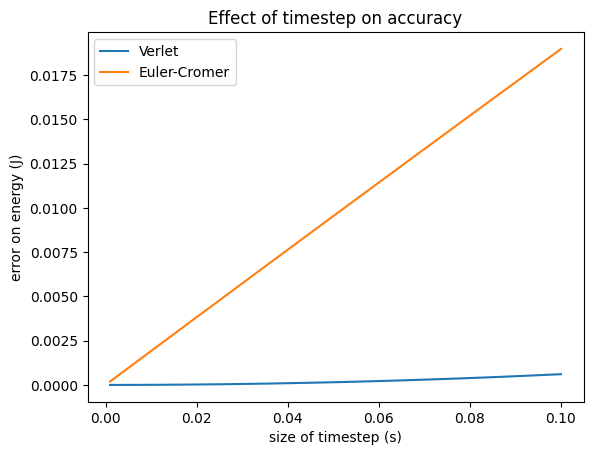

In [20]:
plt.plot(H, err_verlet, label = 'Verlet')
plt.plot(H, err_eucr, label = 'Euler-Cromer')
plt.legend()
plt.title('Effect of timestep on accuracy')
plt.xlabel('size of timestep (s)')
plt.ylabel('error on energy (J)')
plt.show()

Excluding the first two methods from the plot, we can see that both for the Verlet and the Euler-Cromer method, the error increases linearly and so these are the most accurate ones (least affected by the choice of step size, conserving energy and with values closest to the analytical solution).

Either of them is suitable to study the behaviour of the system at different values of the damping constant and with a force applied. The Verlet method was used in the first instance and the Euler-Cromer in the second.

## Effect of damping constant

To study the cases of the system being underdamped (light damping), critically damped and overdamped (heavy damping), we plot the results from the Verlet method for $b = \frac{b_{critical}}{2},  b = b_{critical}$ and $b = 2 b_{critical}$.

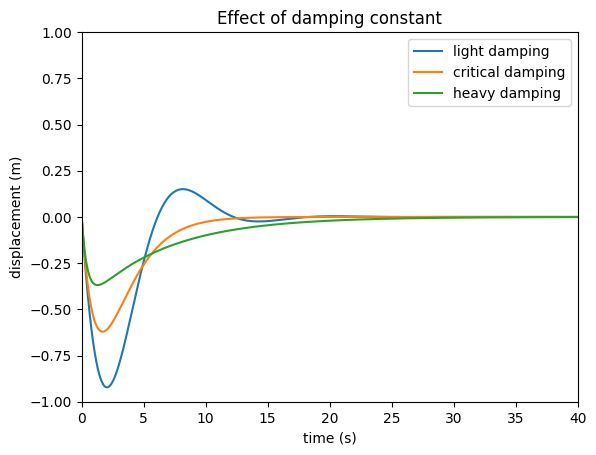

In [21]:
b_critical = np.sqrt(4*k*m)

B = (b_critical/2, b_critical, b_critical*2)
labels = ('light damping', 'critical damping', 'heavy damping')
for index, b in enumerate(B):
    plt.plot(np.arange(0,T,h), Verlet(x0, v0, stepnumber, h)[0], label=labels[index])
plt.xlabel('time (s)')
plt.ylabel('displacement (m)')
plt.title('Effect of damping constant')
plt.legend()
plt.xlim(0, 40)
plt.ylim(-1, 1)
plt.show()

#reset the value of b
b = 0.1

For the underdamped case, the amplitude of oscillations decays exponentially. This is what has been happening before as well, but since $\frac{b_{critical}}{2}$ is larger than the damping value we used for the rest of the project ($b = 0.1$), the decay on this plot is much faster than before.

When the system is critically damped, it returns to its equilibrium state in the shortest amounf of time and no oscillations are detected.

In the heavily damped case, the oscillator slowly returns to the equilibrium position, again, without any oscillations.

## $F(t) \neq 0$

We will now study two cases of an external force applied to the system using the Euler-Cromer method.

First, an instantaneous force applied, which we will model with a Gaussian with a peak around the time the force is applied. We do this both because if the force isn't applied exactly at the start of a time step, it will not be considered by our numerical method of choice and because it is more realistic. A realistic duration time of choice is about 2-3 seconds.

Then, we will look at forced oscillations where the force applied is sinusoidal: $F(t)=F_0sin(\omega t)$, where $\omega \neq \omega_0$ (which is approximately 0.6 for our system).

For both cases, it is important that the sampling frequency is higher than the frequency of the driving force (or its duration) to prevent information loss between steps.

### Sudden force

In [22]:
def Euler_Cromer_sudden_force(x_initial, v_initial, nsteps, stepsize, A, t_app, duration):
    """
    returns an array of displacements and velocities using the Euler-Cromer method, when an external force of amplitude A is
    applied for a duration time at a time t_app, given a step size, total number of steps and initial conditions
    """
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    times = np.arange(0,T,stepsize)
    F = A*(1/(2*np.pi*duration))*np.exp(-(times - t_app)**2/(2*duration**2)) #magnitude of the force at the same time steps
    x[0] = x_initial
    v[0]= v_initial
    
    for i in range(nsteps-1):
        # acceleration at step i
        a = -(k/m)*x[i] - (b/m)*v[i] + F[i]/m #extra acceleration term from the force
        
        v[i+1] = v[i] + stepsize*a
        x[i+1] = x[i] + stepsize*v[i+1]
    
    return (x, v)

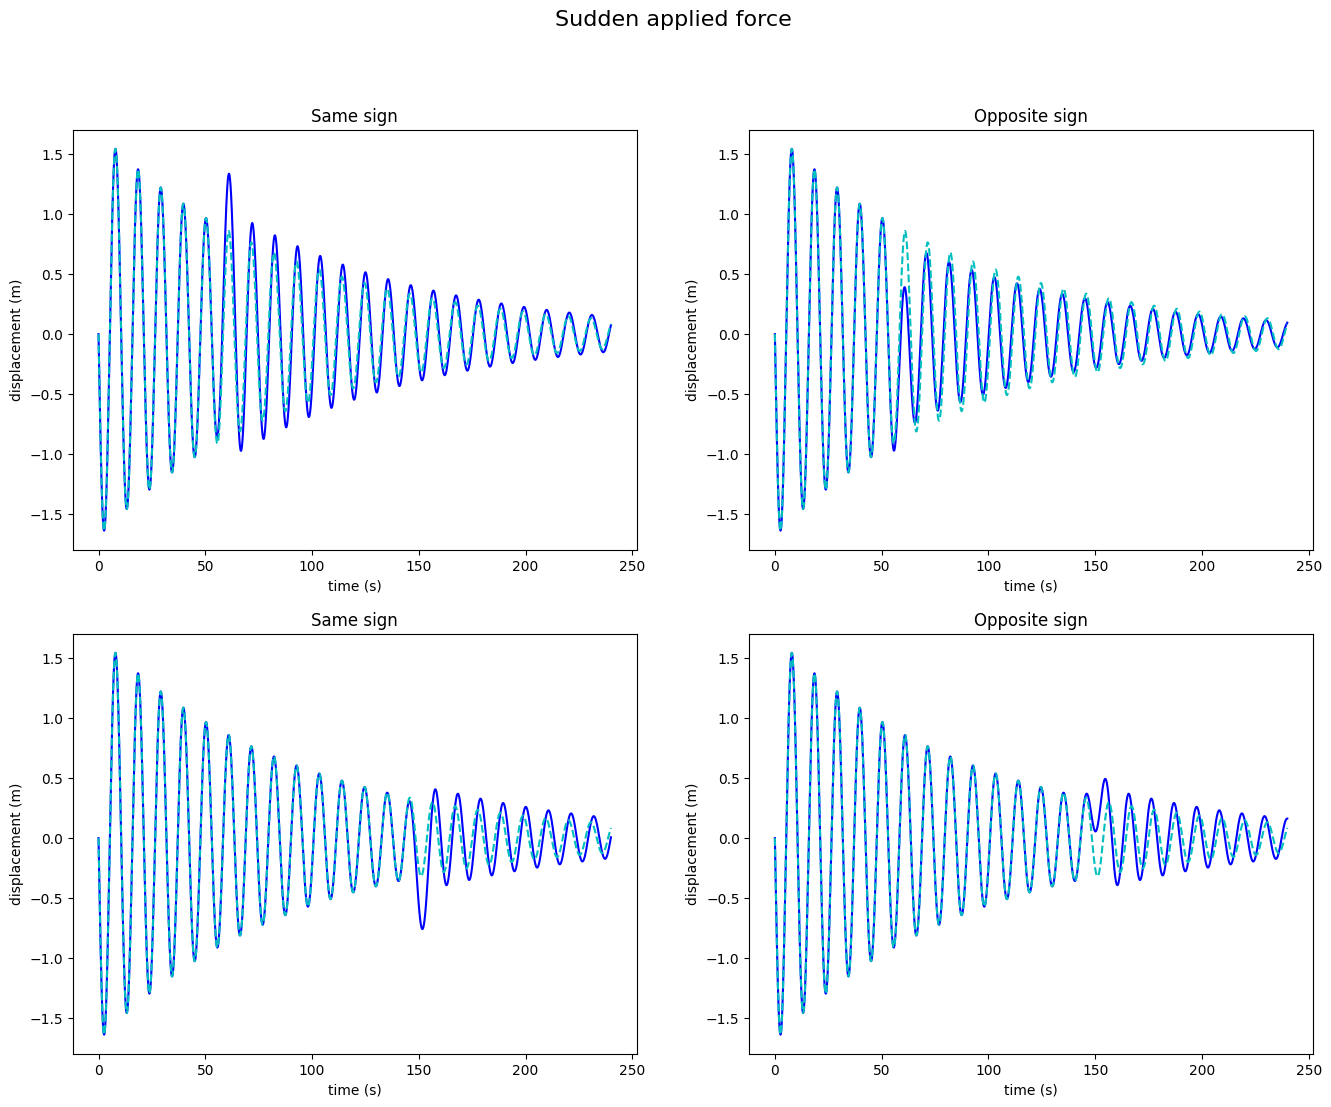

In [23]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(16)
fig.suptitle("Sudden applied force", fontsize=16)

ax[0, 0].plot(np.arange(0,T,h), Euler_Cromer_sudden_force(x0,v0,stepnumber,h, 10, 60, 3)[0], 'b')
ax[0, 0].plot(np.arange(0,T,h), Euler_Cromer(x0,v0,stepnumber,h)[0], 'c--')
ax[0, 0].set_xlabel('time (s)')
ax[0, 0].set_ylabel('displacement (m)')
ax[0, 0].set_title('Same sign')

ax[0, 1].plot(np.arange(0,T,h), Euler_Cromer_sudden_force(x0,v0,stepnumber,h, -10, 60, 3)[0], 'b')
ax[0, 1].plot(np.arange(0,T,h), Euler_Cromer(x0,v0,stepnumber,h)[0], 'c--')
ax[0, 1].set_xlabel('time (s)')
ax[0, 1].set_ylabel('displacement (m)')
ax[0, 1].set_title('Opposite sign')

ax[1, 0].plot(np.arange(0,T,h), Euler_Cromer_sudden_force(x0,v0,stepnumber,h, -10, 151, 3)[0], 'b') #A, t_app, dur
ax[1, 0].plot(np.arange(0,T,h), Euler_Cromer(x0,v0,stepnumber,h)[0], 'c--')
ax[1, 0].set_xlabel('time (s)')
ax[1, 0].set_ylabel('displacement (m)')
ax[1, 0].set_title('Same sign')

ax[1, 1].plot(np.arange(0,T,h), Euler_Cromer_sudden_force(x0,v0,stepnumber,h, 10, 151, 3)[0], 'b')
ax[1, 1].plot(np.arange(0,T,h), Euler_Cromer(x0,v0,stepnumber,h)[0], 'c--')
ax[1, 1].set_xlabel('time (s)')
ax[1, 1].set_ylabel('displacement (m)')
ax[1, 1].set_title('Opposite sign')

plt.show()

The figures above show the oscillation with the applied force in blue and the oscillation with the same parameters but without a force applied in light blue.

Applying a force with the same sign as the instantaneous velocity will amplify the oscillations, while applying one with the opposite sign will decrease the amplitude. If the force is applied at a later time (when the oscillation has decayed significantly), a force applied in the opposite direction can overpower the existing oscillation (as seen on the fourth plot) and in a way, starts a new one with new initial conditions. Depending on when it is applied, the force can also cause a slight phase shift compared to the unforced case.

### Forced oscillations

In [24]:
def Euler_Cromer_periodic_force(x_initial, v_initial, nsteps, stepsize, A, driving_freq):
    """
    returns an array of displacements and velocities of the oscillation and the magnitudes of the driving force
    using the Euler-Cromer method, when a periodic force with a frequency of driving_freq and a magnitude A is applied,
    given a step size, total number of steps and initial conditions
    """
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    times = np.arange(0,T,stepsize)
    F = A*np.sin(driving_freq*times)
    x[0] = x_initial
    v[0]= v_initial
    
    for i in range(nsteps-1):
        # acceleration at step i
        a = -(k/m)*x[i] - (b/m)*v[i] + F[i]/m
        v[i+1] = v[i] + stepsize*a
        x[i+1] = x[i] + stepsize*v[i+1]
    
    return (x, v, F)

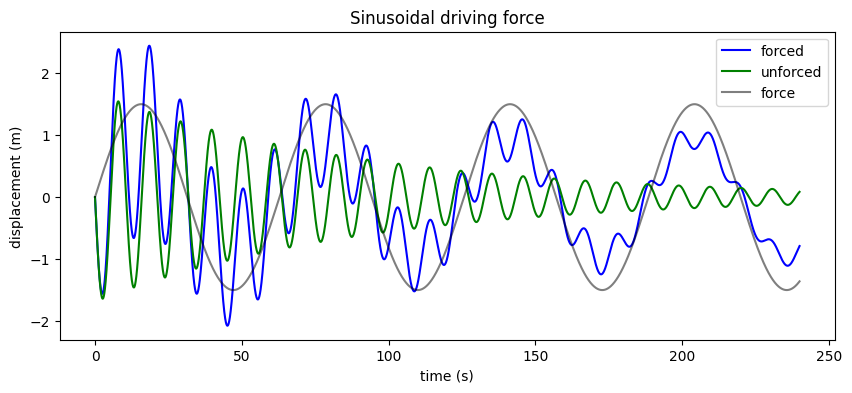

In [25]:
plt.figure(figsize = (10,4))
plt.plot(np.arange(0,T,h), Euler_Cromer_periodic_force(x0,v0,stepnumber,h, 1.5, 0.1)[0], 'b', label = 'forced')
plt.plot(np.arange(0,T,h), Euler_Cromer(x0,v0,stepnumber,h)[0], 'g', label = 'unforced')
plt.plot(np.arange(0,T,h), Euler_Cromer_periodic_force(x0,v0,stepnumber,h, 1.5, 0.1)[2], 'black', alpha = 0.5, label = 'force')
plt.xlabel('time (s)')
plt.ylabel('displacement (m)')
plt.title('Sinusoidal driving force')
plt.legend()
plt.show()

From the plot produced, we can see that the forced oscillation initially slightly resembles the unforced one: it looks like the unforced motion about a moving equilibrium. As the system evolves with time, the force overpowers the oscillation and the motion gets closer and closer to being the same as the driving force itself. This is due to the fact that the damping affects the oscillations, but not the driving force, so after all of the initial velocity and energy is gone, only the driving force remains.